### Читаем результат детектора и изображения

In [1]:
import cv2
from PIL import Image
import numpy as np

from IPython.display import display

In [2]:
# Читаем все изображения из директории
def read_all_images_from(directory):
    from os import listdir
    from os.path import isfile, join
    images = []
    for file in listdir(directory):
        file_path = join(directory, file)
        if isfile(file_path):
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            images.append(image)
    return images

In [3]:
segmaps_path = "./Test/Segmaps"
images_path = "./Test/Image"
segmaps = read_all_images_from(segmaps_path)
images = read_all_images_from(images_path)
assert len(segmaps) == len(images)

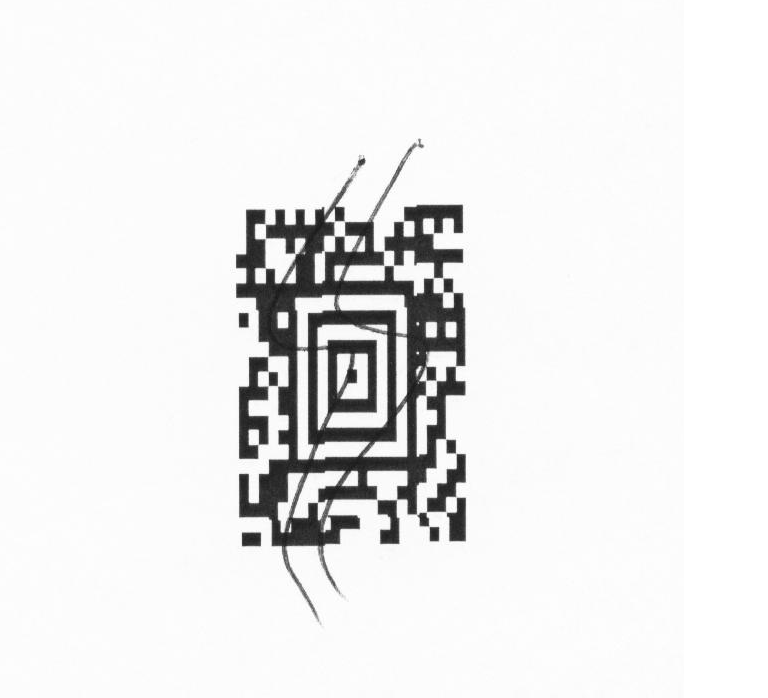

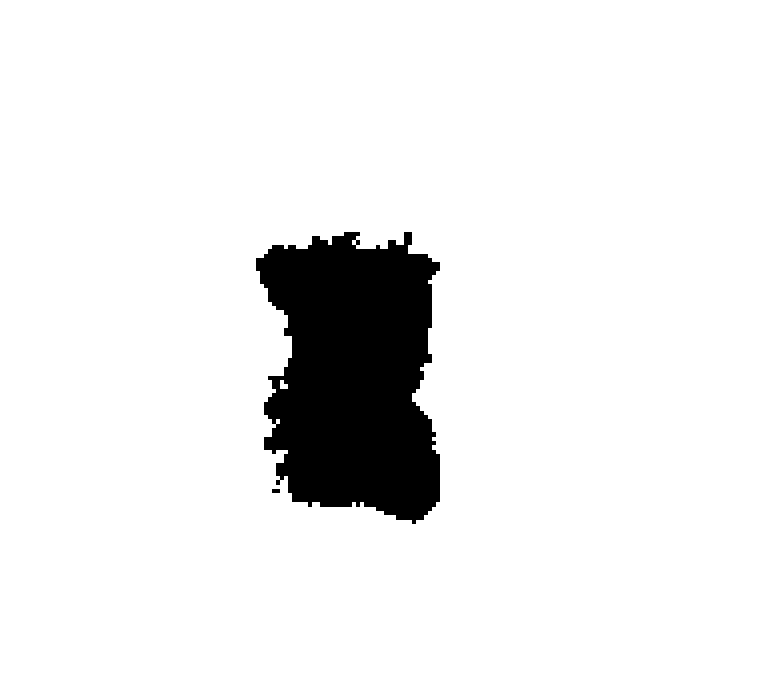

In [4]:
# Посмотрим, что там у нас с данными
display(Image.fromarray(images[0]))
display(Image.fromarray(segmaps[0]))

### Оказалось, гипотеза на карте сегментации немного меньше, чем сам баркод. Можно регион прямоугольника попробовать настроить

In [5]:
# Собираем гипотезы с карты сегментации.
# Возвращает лист повернутых прямоугольников
def get_barcodes_rects(segmap):
    # Собираем компоненты
    # Слишком мелкие не учитываем
    min_area = 10
    binary_map = np.where(segmap < 128, 1, 0)
    binary_map = np.array(binary_map, dtype=np.uint8)
    cnts, _ = cv2.findContours(binary_map, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    cnts = list(filter(lambda cnt: cv2.contourArea(cnt) > min_area, cnts))
    boxes = [cv2.boxPoints(cv2.minAreaRect(cnt)) for cnt in cnts]
    assert len(boxes) == len(cnts)
    return boxes

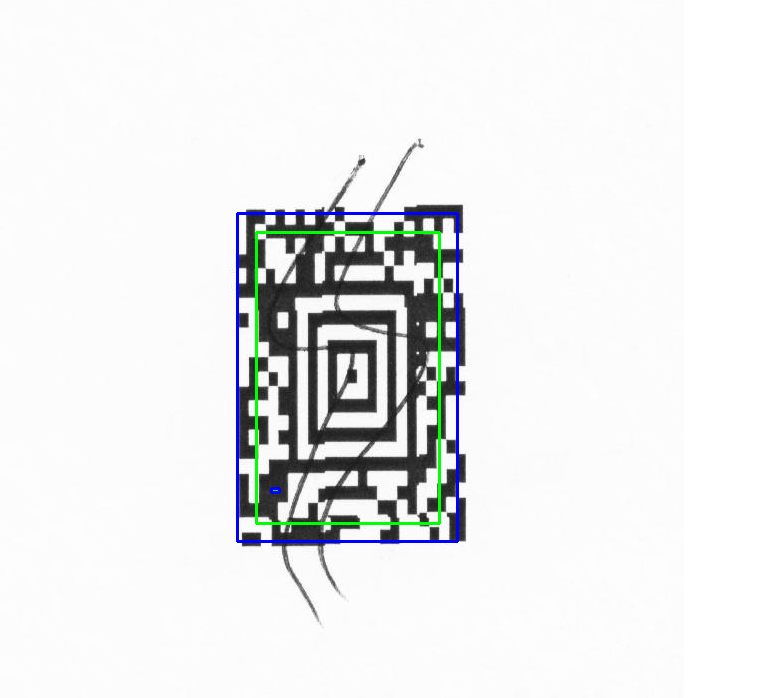

In [6]:
import math

# Расширяем прямоугольник
def scale_single_box(rotated_box):
        ratio = 0.1
        border_points = np.reshape(rotated_box, (-1, 2)).astype(np.float)
        # т.к. прямоугольник, берем минимум из двух сторон
        min_side = min(np.linalg.norm(border_points[0] - border_points[1]),
                       np.linalg.norm(border_points[1] - border_points[2]))
        indent = ratio * min_side
        new_border_points = []
        for idx, point in enumerate(border_points):
            first_side_vector = border_points[idx - 1] - point
            first_side_vector /= np.linalg.norm(first_side_vector)
            second_side_vector = border_points[idx + 1 - border_points.shape[0]] - point
            second_side_vector /= np.linalg.norm(second_side_vector)

            new_point = point - indent * (first_side_vector + second_side_vector)
            new_border_points.append(new_point)
        return np.asarray(new_border_points)


# Получим все гипотезы с изображения
hypotheses = get_barcodes_rects(segmaps[0])

# Для отрисовки границы сделаем изображение цветным
img = cv2.cvtColor(images[0], cv2.COLOR_GRAY2RGB)

# Зеленым будет нарисован самый простой вариант
# Синим нарисован расширенный вариант
for hypothesis in hypotheses:
    new_box = np.int0(hypothesis)
    cv2.drawContours(img, [new_box], 0, (0, 255, 0), 2)
    new_box = scale_single_box(new_box).astype(np.int)
    cv2.drawContours(img, [new_box], 0, (0, 0, 255), 2)
display(Image.fromarray(img))

### Ниже видно, что между штрихкодами есть просветы, можно по ним резать

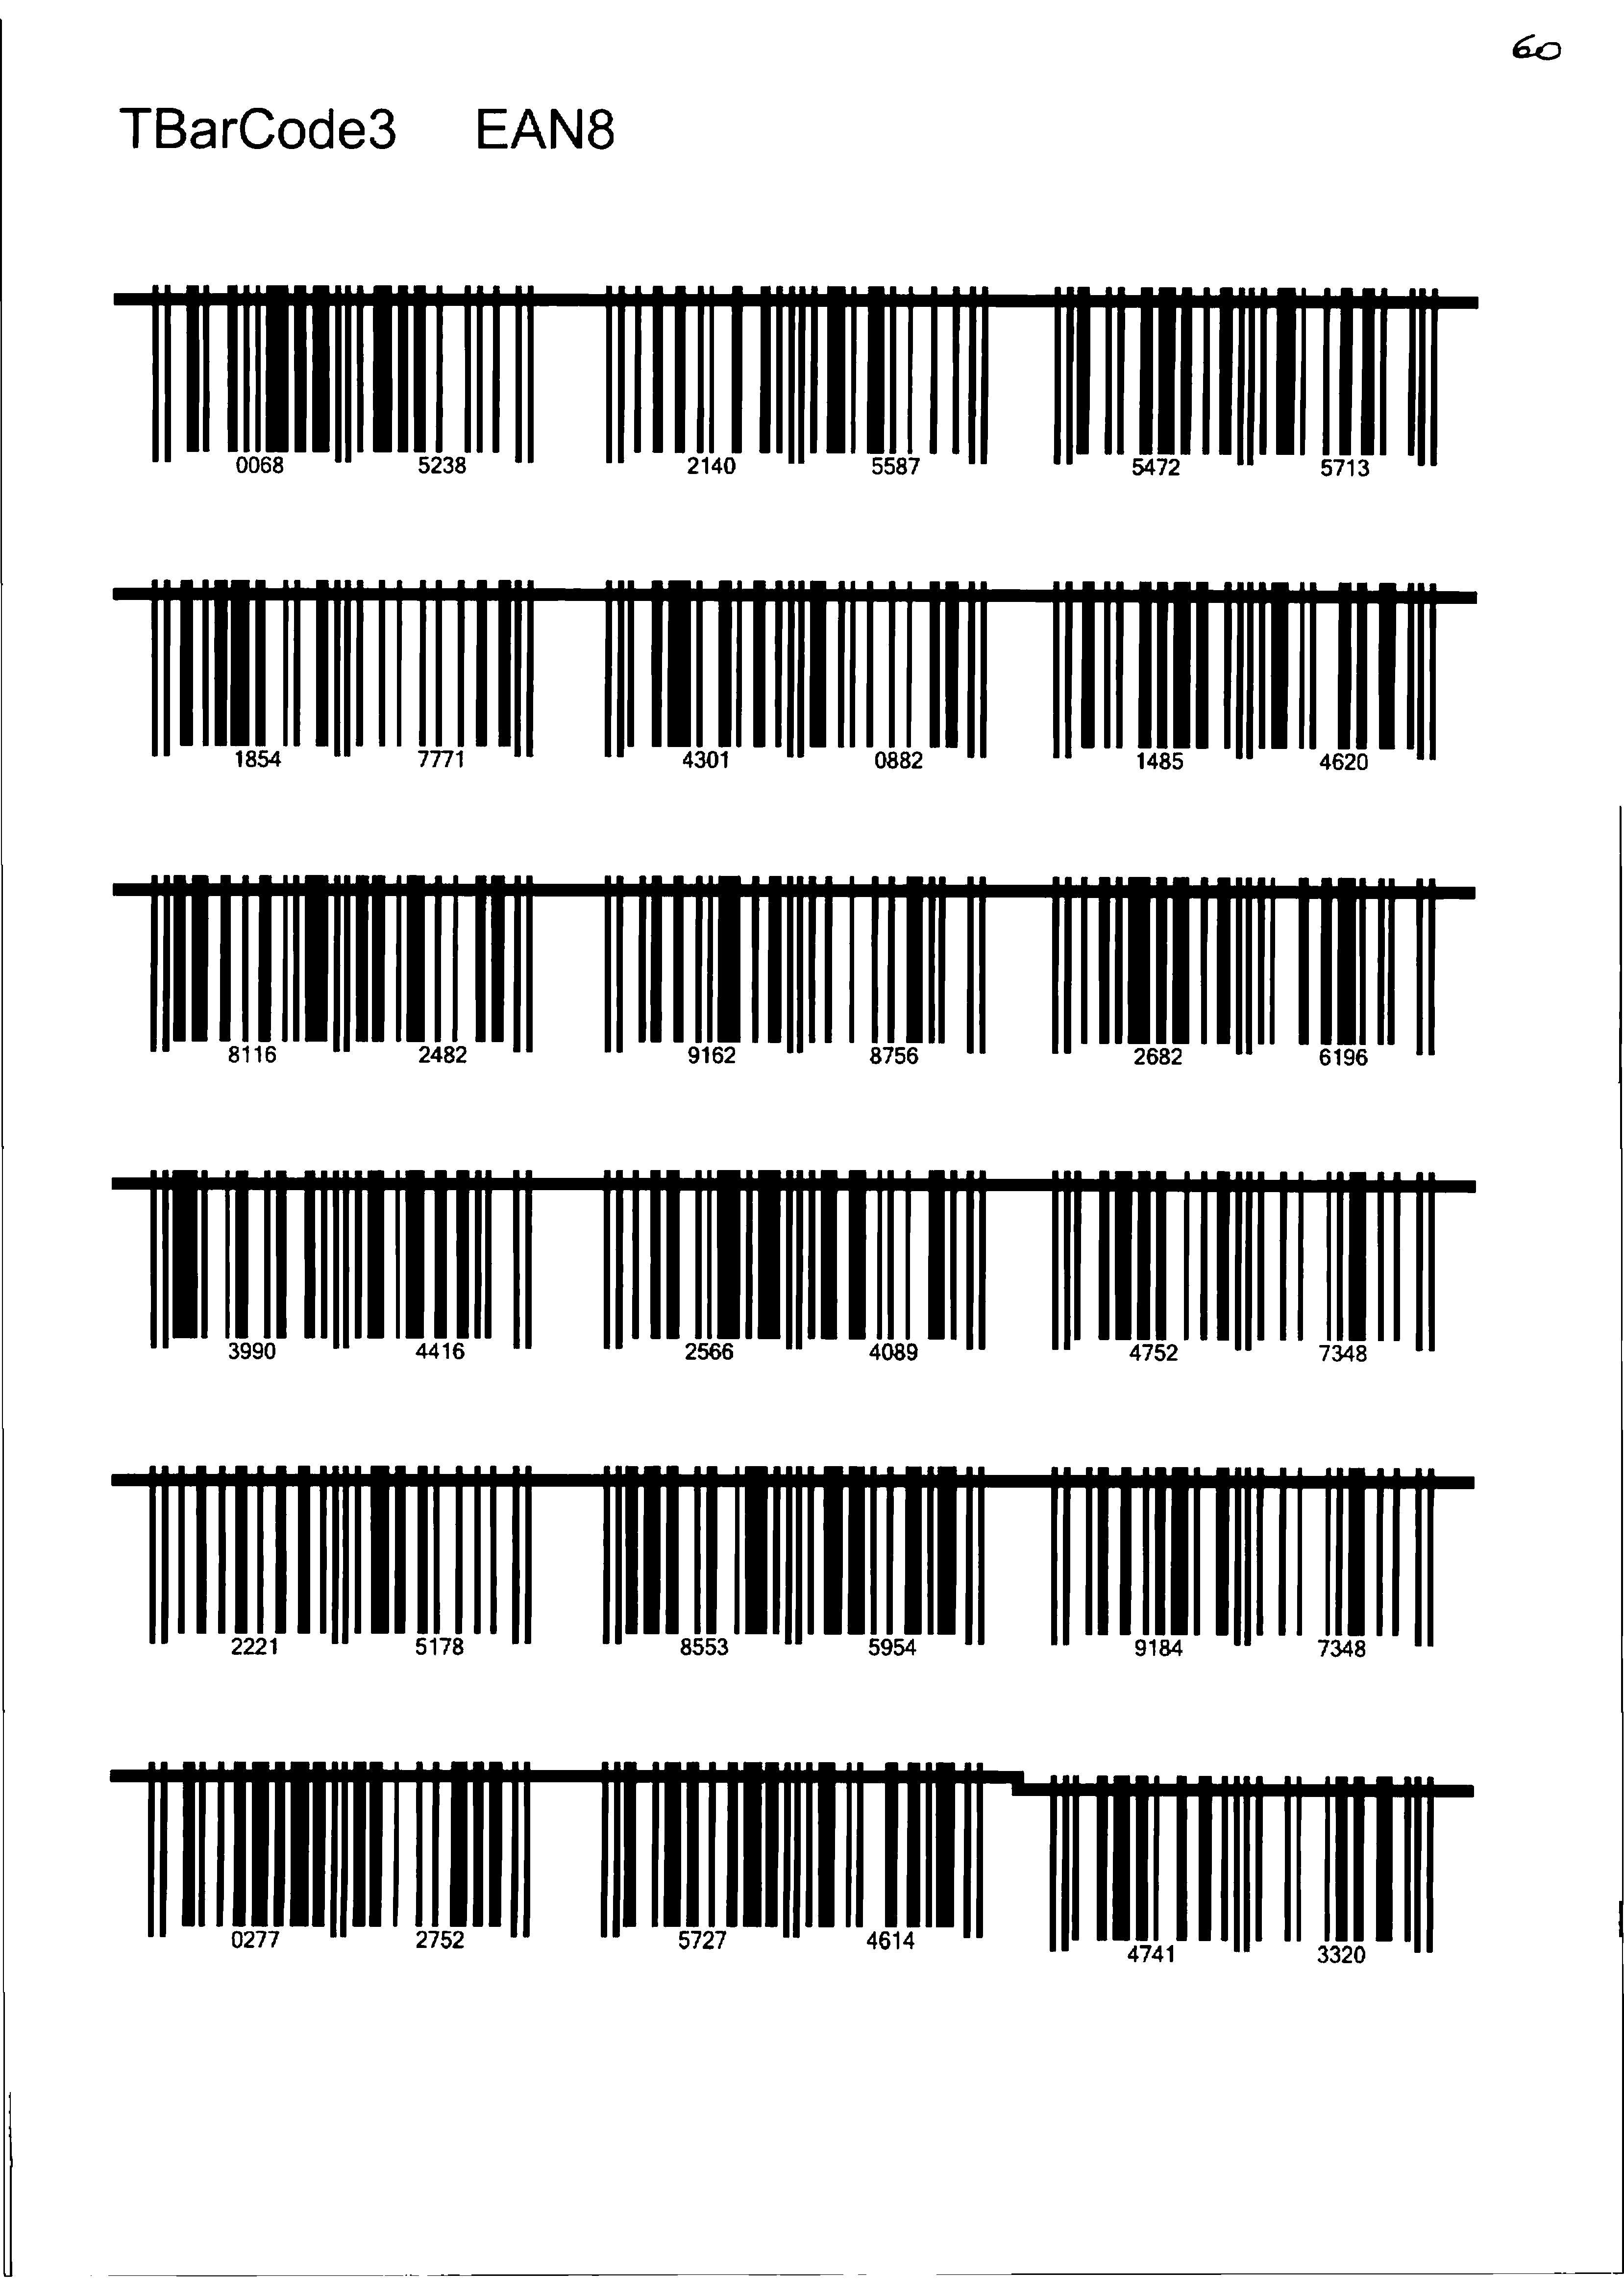

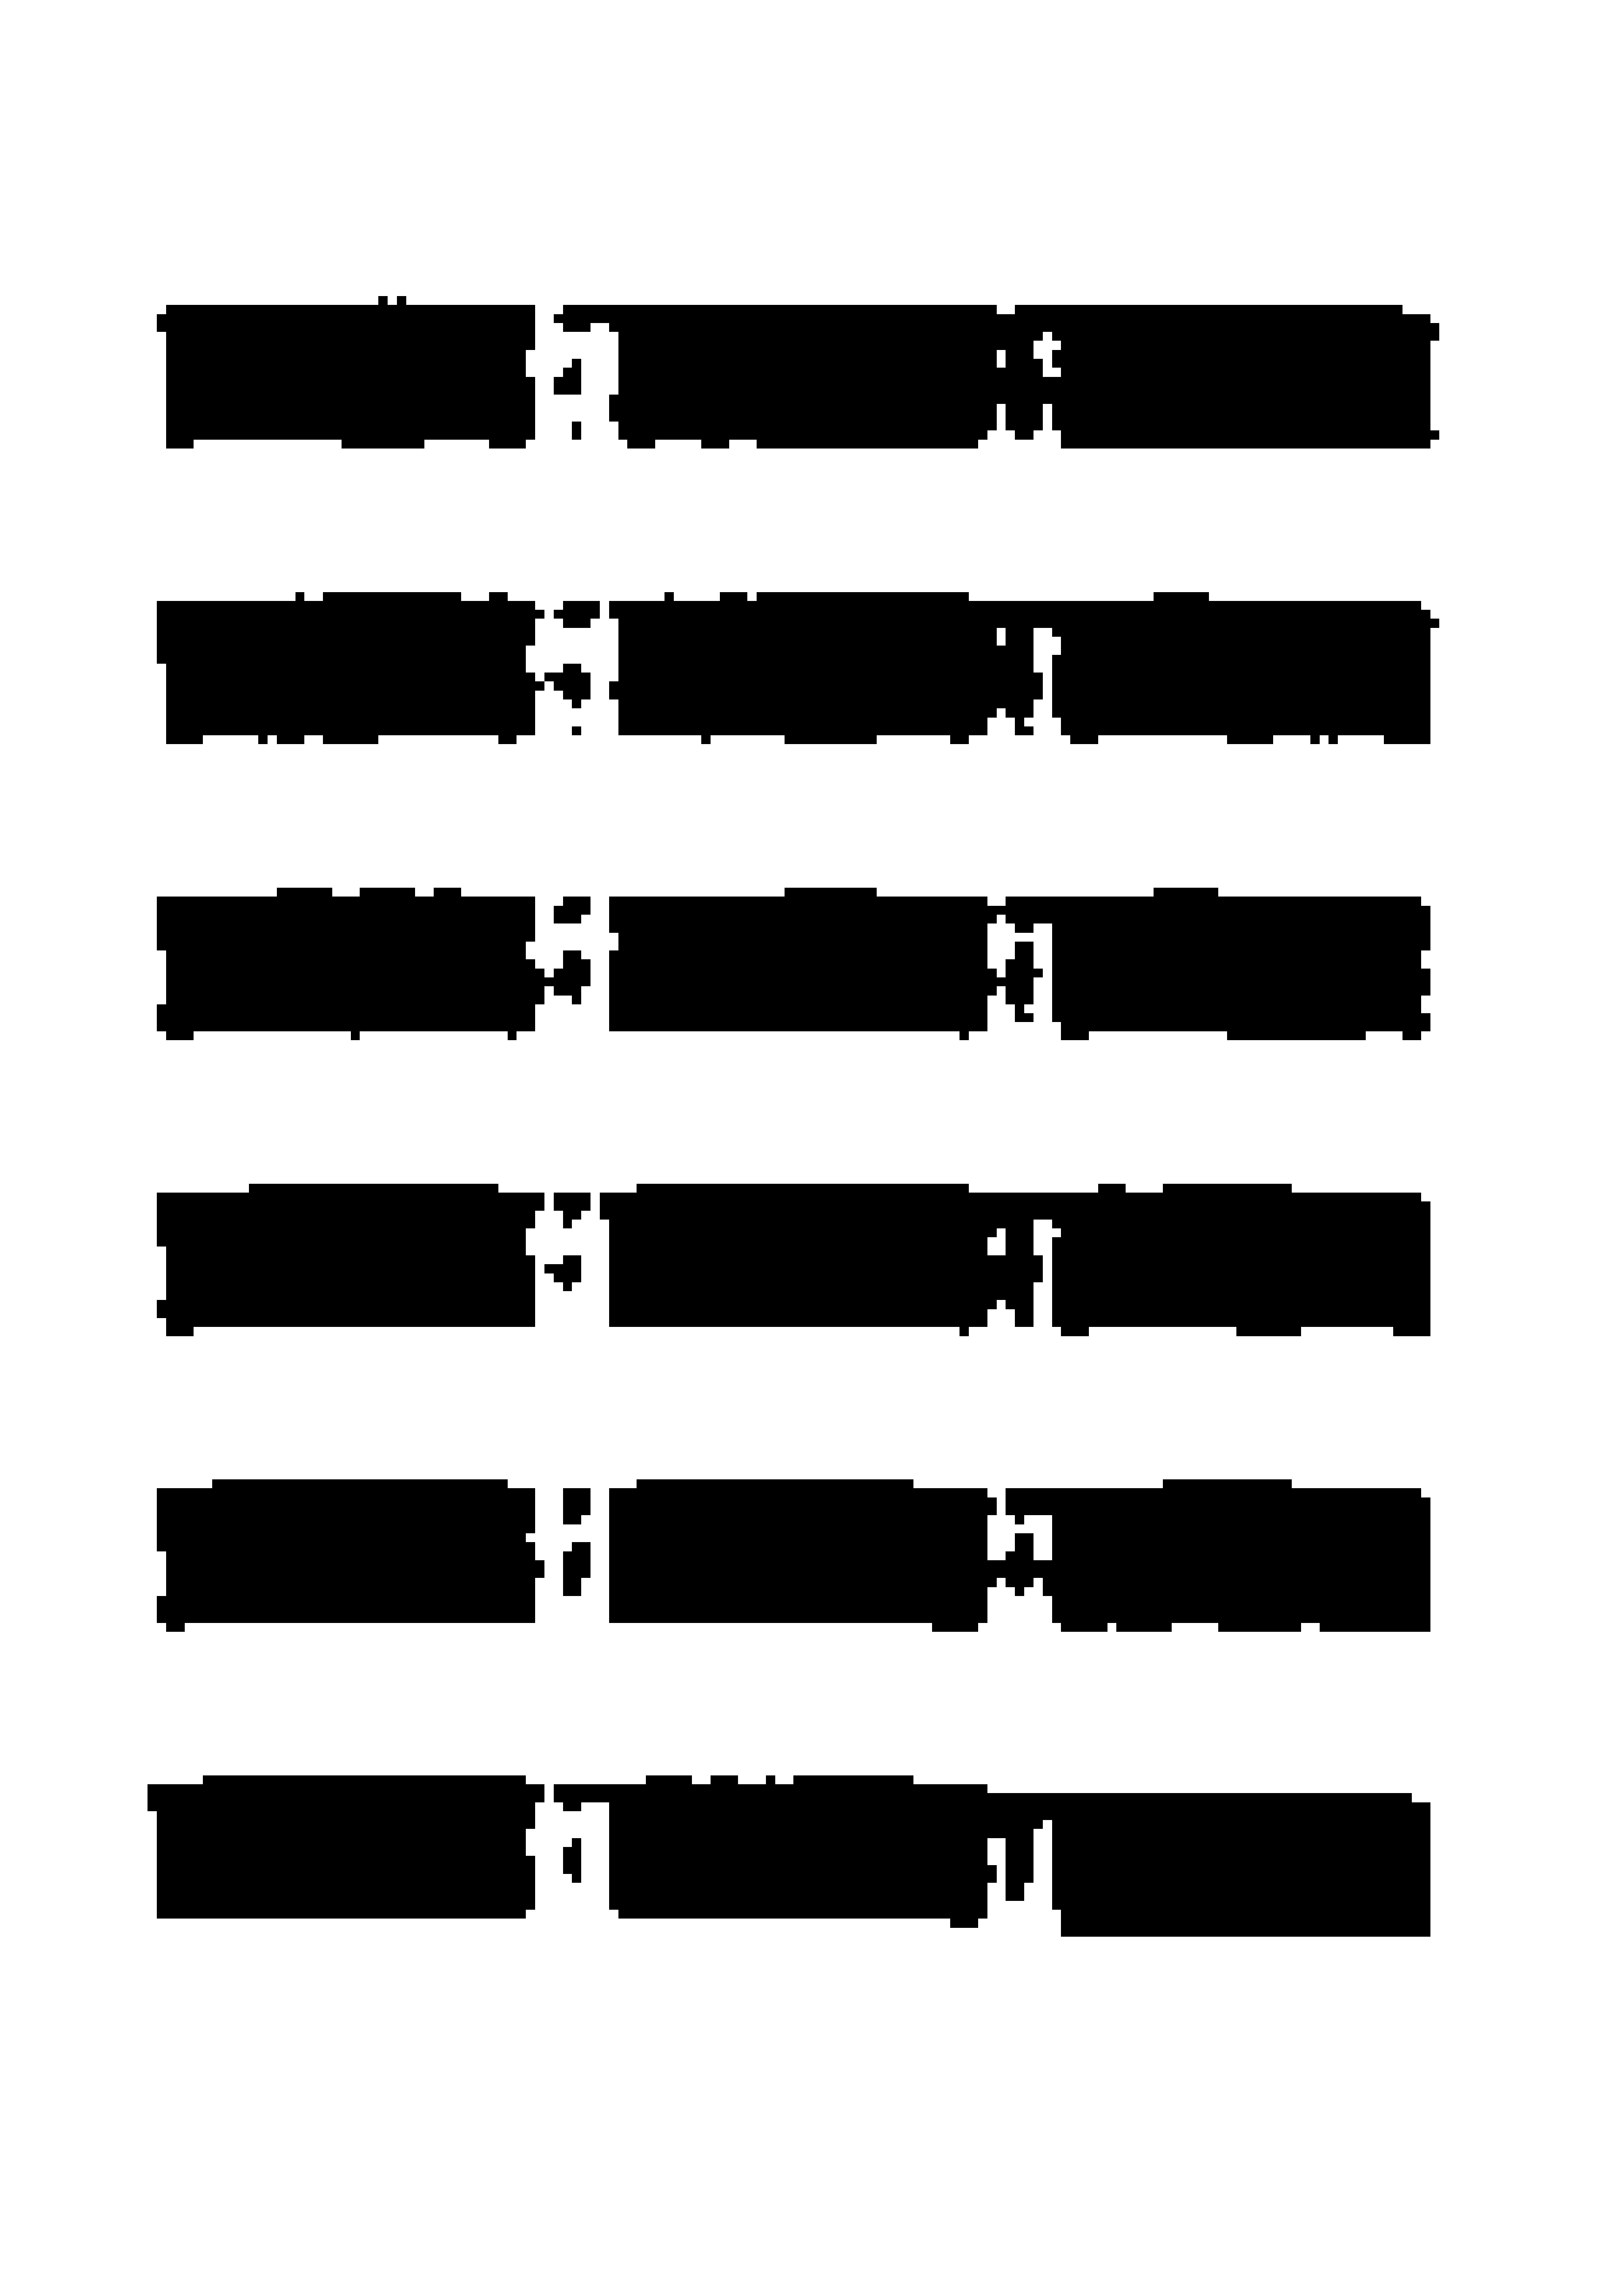

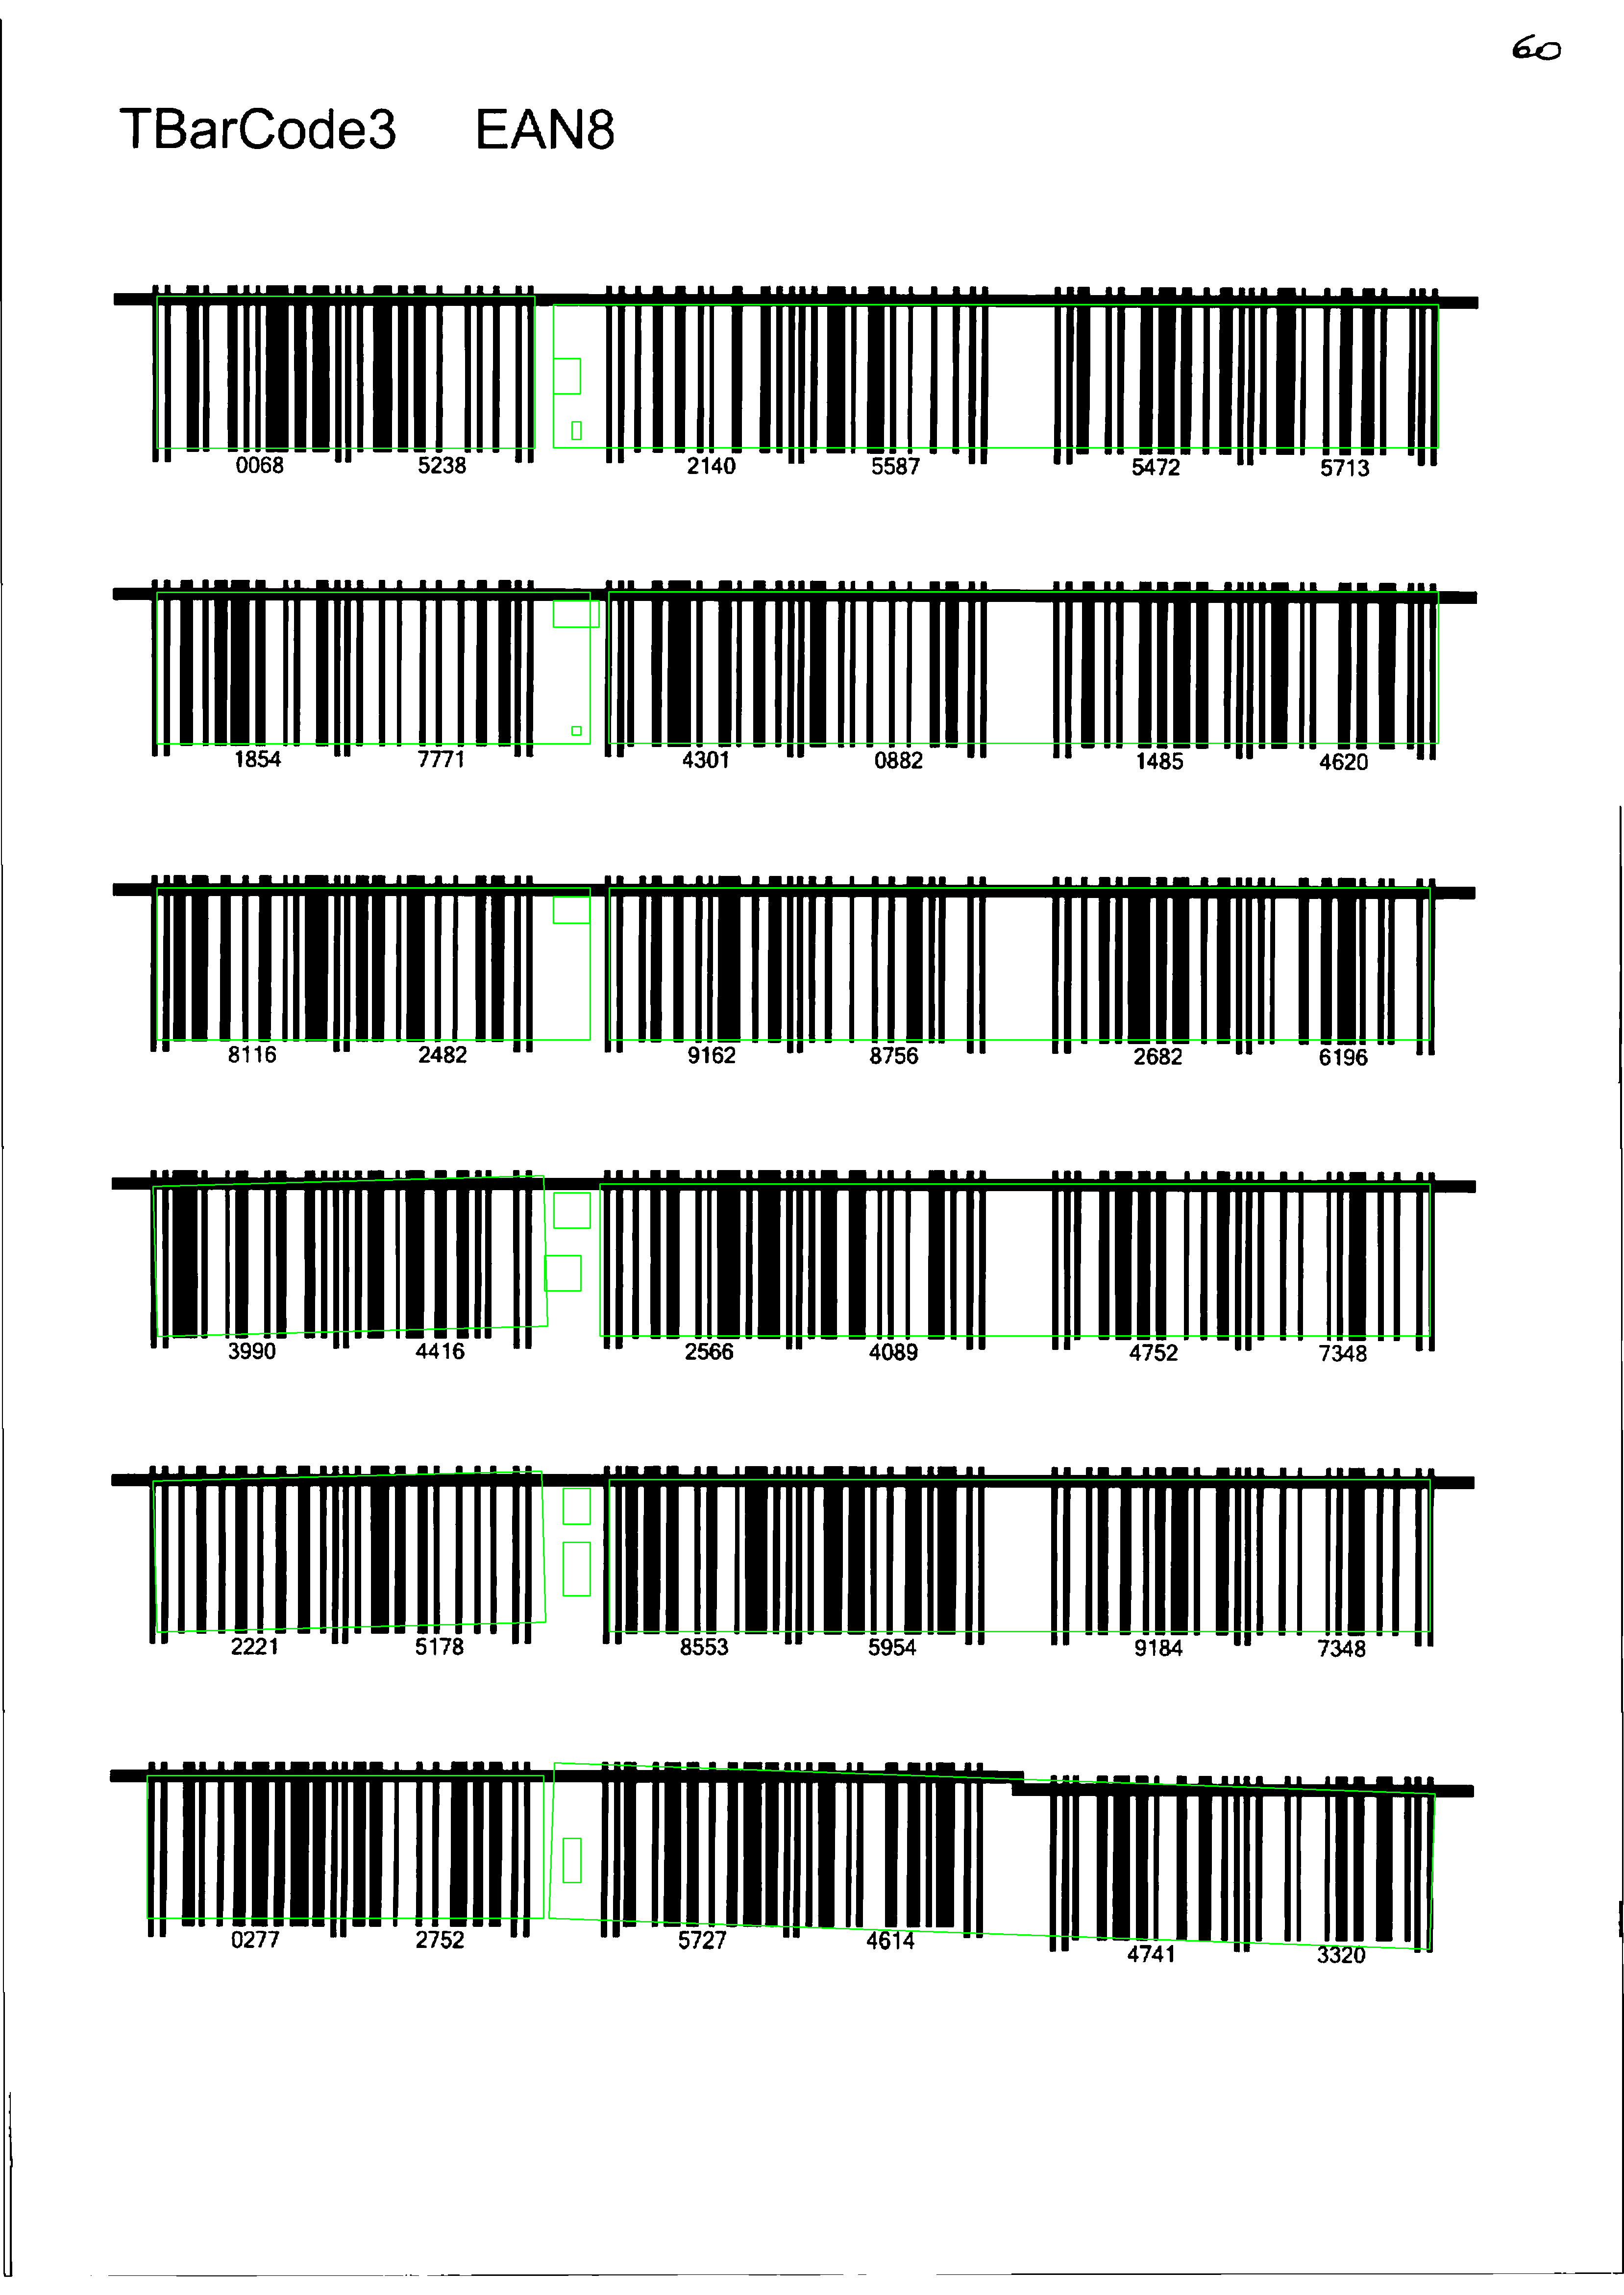

In [7]:
display(Image.fromarray(images[1]))
display(Image.fromarray(segmaps[1]))
hypotheses = get_barcodes_rects(segmaps[1])
img = cv2.cvtColor(images[1], cv2.COLOR_GRAY2RGB)
for hypothesis in hypotheses:
    new_box = np.int0(hypothesis)
    cv2.drawContours(img, [new_box], 0, (0, 255, 0), 2)
display(Image.fromarray(img))

Можно вырезать гипотезу из изображения, сложить значения всех пикселей в каждом столбце изображения и мы получим массив значений -
проекцию изображения на горизонтальную ось. Уже на ней можно найти отрезки с низким значением и по ним порезать. Так мы поймаем
белые просветы в гипотезе.

С вертикальной осью можем поступить аналогично.

### Прочие советы

1. На примере выше можно заметить, что есть гипотезы, у которых справа или слева захвачено большое белое поле.
Такие поля можно обрезать.
2. Иногда вместо белого поля по краям изображения есть незначительный сигнал - шум.
Его тоже можно отрезать для повышения точности границ гипотезы.
3. Карта сегментации может "распадаться" либо на больших штрихкодах, либо на совсем мелких. Здесь стоит подумать над алгоритмом, который сможет склеивать мелкие запчасти в целый кусок.

Ну а здесь в качестве baseLine сделаем только scale гипотезы и покажем, как правильно писать в файл

In [8]:
result = []
for i, segmap in enumerate(segmaps):
    hypotheses = get_barcodes_rects(segmap)
    current_result = []
    for hypothesis in hypotheses:
        new_box = np.int0(hypothesis)
        new_box = scale_single_box(new_box).astype(np.int)
        current_result.append(new_box)
    result.append(current_result)  

In [9]:
print(len(result))
print(result[0])

181
[array([[271, 488],
       [279, 488],
       [279, 492],
       [271, 492]]), array([[237, 213],
       [457, 213],
       [457, 541],
       [237, 541]])]


### Пишем результат в файл

In [10]:
import csv

# Записываем координаты области в виде [x0, y0];[x1, y1];[x2, y2];[x3, y3]
def format_rotated_box_string(points):
    assert len(points) == 4
    str_res = ""
    for pair in points:
        str_res = str_res + f"[{pair[0]}, {pair[1]}];"
    return str_res[:-1]
        
        
with open('./output.tsv', 'wt', newline="") as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    from os import listdir
    for i, file in enumerate(listdir(images_path)):
        import os
        only_name = os.path.splitext(file)[0]
        for res in result[i]:
            tsv_writer.writerow([only_name, format_rotated_box_string(res)])
